Once you've set up the repos and grabbed the pretrained checkpoints, instantiating DorsalNet is pretty easy.

In [1]:
import numpy as np
import pandas as pd
import torch

import sys
sys.path.append('../')
from paths import *
from python_dict_wrapper import wrap


features = 'airsim_04'

args = wrap({'features': features,
             'ckpt_root': CHECKPOINTS,
             'slowfast_root': None,
             'ntau': 32,
             'nt': 1,
             'subsample_layers': False})

from models import get_feature_model

model, hooks, data = get_feature_model(args)
model

DorsalNet(
  (s1): ShallowNet(
    (conv1): Conv3d(3, 64, kernel_size=[5, 7, 7], stride=[1, 2, 2], padding=[2, 3, 3], bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    (dropout): Dropout3d(p=0, inplace=False)
  )
  (res0): ResBlock(
    (branch1): Conv3d(64, 32, kernel_size=(1, 1, 1), stride=[1, 1, 1], bias=False)
    (branch1_bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (branch2): BottleneckTransform(
      (a): Conv3d(64, 8, kernel_size=[1, 1, 1], stride=[1, 1, 1], padding=[0, 0, 0], bias=False)
      (a_bn): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a_relu): ReLU(inplace=True)
      (b): Conv3d(8, 8, kernel_size=[1, 3, 3], stride=[1, 1, 1], padding=[0, 1, 1], dilation=[1

You can get the final 5-way output for some input X using model(X). The inputs should be in the order `(batch_size, nchannels, nt, ny, nx)`. However, what we usually care about are the values in the intermediate layer, which we can get from hooks. Here I show how to derive a tuning curve for drifting gratings from intermedate layers. The inputs should generally be scaled and centered so that the neutral value is 0 and the sd is around 1.

In [2]:
def create_drifting_gratings():
    ntau = 32
    radius = 32
    ndirections = 16

    lx, lt = 16, 16

    # Create stimuli that contain all combos that are needed
    xi, yi = np.meshgrid(np.arange(-55.5, 56.5), np.arange(-55.5, 56.5))
    mask = xi**2 + yi**2 < radius**2
    oi = (np.arange(ndirections) / ndirections * 2 * np.pi).reshape((-1, 1, 1, 1))
    ti = np.arange(ntau)
    ti = ti - ti.mean()

    vals = []
    stims = []

    ri = (np.cos(oi) * xi.reshape((1, 1, xi.shape[0], xi.shape[1])) - np.sin(oi) * yi.reshape((1, 1, xi.shape[0], xi.shape[1])))
    X = mask.reshape((1, 1, xi.shape[0], xi.shape[1])) * np.cos((ri / lx) * 2 * np.pi - ti.reshape((1, -1, 1, 1)) / lt * 2 *np.pi)
    X = np.stack([X, X, X], axis=1) # Go from black and white to RGB
    return X

X = torch.tensor(create_drifting_gratings()).to(device='cuda', dtype=torch.float)
model.to(device='cuda')
model(X)
hooks.keys()

odict_keys(['layer00', 'layer01', 'layer02', 'layer03', 'layer04', 'layer05', 'layer06'])

In [3]:
hooks['layer01'].shape

torch.Size([16, 64, 32, 56, 56])

Show the tuning curve of the first filter of layer 1.

Text(0, 0.5, 'response (A.U.)')

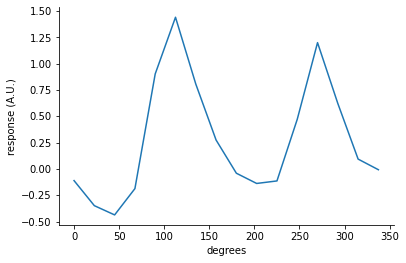

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

filt_num = 0
plt.plot(np.arange(16) / 16 * 360, hooks['layer01'][:, filt_num, 16, 26, 26].detach().cpu().numpy())
sns.despine()
plt.xlabel('degrees')
plt.ylabel('response (A.U.)')